In [56]:
import pandas as pd 
import re
import json
from nltk.tag import pos_tag
from nltk.chunk import conlltags2tree, tree2conlltags
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
import gensim
from gensim import corpora, models
import math
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")
p_stemmer = PorterStemmer()

In [72]:
df = pd.read_csv("sample.csv")
df.info()

## FOR TESTING ONLY
# df = df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29047 entries, 0 to 29046
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    29047 non-null  int64 
 1   title         29047 non-null  object
 2   url           29047 non-null  object
 3   crawled_time  29047 non-null  object
 4   date          29047 non-null  object
 5   domain        29047 non-null  object
 6   author        19635 non-null  object
 7   content       29047 non-null  object
 8   topic_area    29047 non-null  object
dtypes: int64(1), object(8)
memory usage: 2.0+ MB


In [73]:
## Remove stop words and tokenise and stem
def clean_content_SLOW(row):
    content = re.sub("[^0-9a-zA-Z\&]+", " ", row['content']).split(" ")
    processed = [stemmer.stem(lemmatizer.lemmatize(x.lower(), pos='v')) for x in content if x not in stopwords and x.strip() != ""]
    return processed


def clean_content_FAST(row):
    content = re.sub("[^a-zA-Z\&]+", " ", row['content']).split(" ")
    processed = [p_stemmer.stem(x.lower()) for x in content if x not in stopwords and x.strip() != ""]
    return processed


df["processed"] = df.apply(lambda row: clean_content_SLOW(row), axis=1)

In [74]:
dictionary = corpora.Dictionary(df["processed"])
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
print (dictionary)

Dictionary(17086 unique tokens: ['&', '0&placement', '0&userid', '02', '1']...)


In [75]:
bow_corpus = [dictionary.doc2bow(doc) for doc in df["processed"]]
# bow_corpus[69]

# TF-IDF TIME

In [76]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

## Print this if you want see 
# for doc in corpus_tfidf:
#     print (doc)

In [82]:
lda_model = models.LdaMulticore(corpus_tfidf, num_topics=15, id2word=dictionary, passes=2, workers=6)

In [131]:
lda_model[corpus_tfidf[420]]

[(3, 0.5576914), (12, 0.3719116)]

In [117]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic), end="\n\n")

Topic: 0 Word: 0.008*"queen" + 0.008*"royal" + 0.007*"meghan" + 0.006*"princ" + 0.005*"harri" + 0.003*"duke" + 0.003*"palac" + 0.003*"duchess" + 0.003*"flybe" + 0.003*"markl"

Topic: 1 Word: 0.005*"compani" + 0.005*"forward" + 0.004*"statement" + 0.003*"oper" + 0.003*"2019" + 0.003*"2020" + 0.003*"custom" + 0.003*"inform" + 0.003*"look" + 0.003*"com"

Topic: 2 Word: 0.003*"i" + 0.003*"uk" + 0.002*"school" + 0.002*"test" + 0.002*"home" + 0.002*"govern" + 0.002*"case" + 0.002*"newspap" + 0.002*"isol" + 0.002*"go"

Topic: 3 Word: 0.004*"trump" + 0.002*"hous" + 0.002*"democrat" + 0.002*"state" + 0.002*"senat" + 0.002*"worker" + 0.002*"store" + 0.002*"u" + 0.002*"case" + 0.002*"test"

Topic: 4 Word: 0.002*"mortgag" + 0.002*"market" + 0.002*"oil" + 0.002*"china" + 0.002*"bank" + 0.002*"0" + 0.002*"price" + 0.002*"stock" + 0.002*"disney" + 0.002*"dollar"

Topic: 5 Word: 0.003*"buffett" + 0.002*"berkshir" + 0.002*"eldorado" + 0.002*"china" + 0.002*"turkey" + 0.002*"test" + 0.002*"fda" + 0.002*

In [132]:
"""
lda_model = models.LdaMulticore(corpus_tfidf, num_topics=15, id2word=dictionary, passes=2, workers=6)

UK
Topic: 0 Word: 0.008*"queen" + 0.008*"royal" + 0.007*"meghan" + 0.006*"princ" + 0.005*"harri" + 0.003*"duke" + 0.003*"palac" + 0.003*"duchess" + 0.003*"flybe" + 0.003*"markl"
Topic: 11 Word: 0.003*"chelsea" + 0.002*"odoi" + 0.002*"leagu" + 0.002*"china" + 0.002*"callum" + 0.001*"hudson" + 0.001*"willian" + 0.001*"le" + 0.001*"oil" + 0.001*"club"

Financial Impact
Topic: 4 Word: 0.002*"mortgag" + 0.002*"market" + 0.002*"oil" + 0.002*"china" + 0.002*"bank" + 0.002*"0" + 0.002*"price" + 0.002*"stock" + 0.002*"disney" + 0.002*"dollar"
Topic: 5 Word: 0.003*"buffett" + 0.002*"berkshir" + 0.002*"eldorado" + 0.002*"china" + 0.002*"turkey" + 0.002*"test" + 0.002*"fda" + 0.002*"airbus" + 0.001*"compani" + 0.001*"roch"
Topic: 7 Word: 0.005*"bank" + 0.005*"market" + 0.004*"feed" + 0.004*"0" + 0.004*"stock" + 0.003*"bond" + 0.003*"yield" + 0.003*"index" + 0.003*"investor" + 0.003*"rat"
Topic: 9 Word: 0.002*"stock" + 0.002*"appl" + 0.002*"china" + 0.002*"compani" + 0.002*"zoom" + 0.002*"quarter" + 0.002*"share" + 0.002*"breakingview" + 0.002*"nba" + 0.002*"u"
Topic: 10 Word: 0.009*"oil" + 0.005*"price" + 0.004*"barrel" + 0.004*"crude" + 0.004*"opec" + 0.003*"saudi" + 0.003*"bank" + 0.003*"cut" + 0.003*"russia" + 0.003*"market"

Manufacturing
Topic: 8 Word: 0.004*"lme" + 0.003*"automak" + 0.003*"plant" + 0.003*"tonn" + 0.003*"china" + 0.003*"auto" + 0.003*"sunak" + 0.002*"copper" + 0.002*"motor" + 0.002*"vehicl"

Politcal
Topic: 6 Word: 0.004*"biden" + 0.004*"sander" + 0.003*"trump" + 0.003*"i" + 0.003*"facebook" + 0.002*"googl" + 0.002*"campaign" + 0.002*"democrat" + 0.002*"cramer" + 0.002*"game"

Airline
Topic: 13 Word: 0.003*"flight" + 0.002*"travel" + 0.002*"airlin" + 0.002*"test" + 0.002*"uk" + 0.002*"passeng" + 0.002*"itali" + 0.002*"store" + 0.002*"airport" + 0.002*"case"

Travel to/from China
Topic: 12 Word: 0.007*"airlin" + 0.004*"china" + 0.004*"flight" + 0.003*"travel" + 0.002*"hong" + 0.002*"kong" + 0.002*"chines" + 0.002*"air" + 0.002*"beij" + 0.002*"wuhan"

Vaccination
Topic: 14 Word: 0.004*"symptom" + 0.003*"c" + 0.003*"seat" + 0.003*"test" + 0.003*"studi" + 0.003*"vaccin" + 0.002*"leagu" + 0.002*"infect" + 0.002*"mask" + 0.002*"percent"

Lifestyle Impact
Topic: 2 Word: 0.003*"i" + 0.003*"uk" + 0.002*"school" + 0.002*"test" + 0.002*"home" + 0.002*"govern" + 0.002*"case" + 0.002*"newspap" + 0.002*"isol" + 0.002*"go"

Company 
Topic: 1 Word: 0.005*"compani" + 0.005*"forward" + 0.004*"statement" + 0.003*"oper" + 0.003*"2019" + 0.003*"2020" + 0.003*"custom" + 0.003*"inform" + 0.003*"look" + 0.003*"com"
"""

'\nlda_model = models.LdaMulticore(corpus_tfidf, num_topics=15, id2word=dictionary, passes=2, workers=6)\n\nUK\nTopic: 0 Word: 0.008*"queen" + 0.008*"royal" + 0.007*"meghan" + 0.006*"princ" + 0.005*"harri" + 0.003*"duke" + 0.003*"palac" + 0.003*"duchess" + 0.003*"flybe" + 0.003*"markl"\nTopic: 11 Word: 0.003*"chelsea" + 0.002*"odoi" + 0.002*"leagu" + 0.002*"china" + 0.002*"callum" + 0.001*"hudson" + 0.001*"willian" + 0.001*"le" + 0.001*"oil" + 0.001*"club"\n\nFinancial Impact\nTopic: 4 Word: 0.002*"mortgag" + 0.002*"market" + 0.002*"oil" + 0.002*"china" + 0.002*"bank" + 0.002*"0" + 0.002*"price" + 0.002*"stock" + 0.002*"disney" + 0.002*"dollar"\nTopic: 5 Word: 0.003*"buffett" + 0.002*"berkshir" + 0.002*"eldorado" + 0.002*"china" + 0.002*"turkey" + 0.002*"test" + 0.002*"fda" + 0.002*"airbus" + 0.001*"compani" + 0.001*"roch"\nTopic: 7 Word: 0.005*"bank" + 0.005*"market" + 0.004*"feed" + 0.004*"0" + 0.004*"stock" + 0.003*"bond" + 0.003*"yield" + 0.003*"index" + 0.003*"investor" + 0.003*"r

In [119]:
lda_model[corpus_tfidf[5]]

[(14, 0.93333924)]

In [120]:
print (len(corpus_tfidf))

29047


In [123]:
# Get distribution of topics and articles
def getMajorTopic(arr):
    max_percentage = 0
    topic = -1
    for tup in arr:
        if tup[1] > max_percentage:
            max_percentage = tup[1]
            topic = tup[0]
    return topic, max_percentage


topic_distribution = {}
for i in range(len(corpus_tfidf)):
    val = lda_model[corpus_tfidf[i]]
    topic, max_percentage = getMajorTopic(val)
    if topic_distribution.get(topic, False) == False:
        topic_distribution[topic] = 0
    topic_distribution[topic] += 1

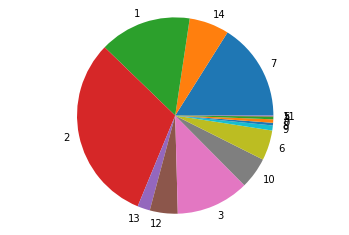

In [128]:
import matplotlib.pyplot as plt

# Data to plot
labels = topic_distribution.keys()
sizes = topic_distribution.values()

# Plot
plt.pie(sizes,labels=labels)

plt.axis('equal')
plt.show()